## Introduction

In this notebook we will look at inference attacks against an MNIST classifier.
Specifically, we will use the ART implementation of Fredrikson et al.'s (2015) MI-Face algorithm.

In [38]:
import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
from numpy.random import seed
seed(123)

from art.estimators.classification import KerasClassifier
from art.attacks.inference.model_inversion.mi_face import MIFace
from art.utils import load_dataset

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [39]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical, plot_model

In [40]:
Cifar10=keras.datasets.cifar10 # Loading the dataset

(x_train,y_train),(x_test,y_test)= Cifar10.load_data()

num_classes = len(np.unique(y_train))
print(num_classes)

10


In [41]:
print(y_train)


[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


In [45]:
# Modelling - Model on CNN

from tensorflow.keras import models, layers
from keras.layers import Conv2D, MaxPooling2D, Flatten , Dense, Activation,Dropout

# create a sequential model i.e. empty neural network which has no layers in it.
model=models.Sequential()

#==================== Feature Detection / extraction Block ====================#

# Add first convolutional block - To deal with images we use Conv2D and for colour images and shape use Conv3D
#model.add(layers.Conv2D(filters=6, kernal_size(3,3), input_shape=(32,32,1), activation='relu'))
# in the first block we need to mention input_shape
model.add(layers.Conv2D(64,(3,3),input_shape=(32,32,3),activation='relu'))
model.add(layers.Conv2D(64,(3,3),input_shape=(32,32,3),activation='relu'))
# Add the max pooling layer
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Add Second convolutional block
#model.add(layers.Conv2D(filters=6, kernal_size(3,3), activation='relu'))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
# Add the max pooling layer
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# Add Third convolutional block
#model.add(layers.Conv2D(filters=6, kernal_size(3,3), activation='relu'))
model.add(layers.Conv2D(256,(3,3),activation='relu'))
# model.add(layers.Conv2D(256,(3,3),activation='relu'))
# Add the max pooling layer
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


# Add Flatten layer. Flatten simply converts matrics to array
model.add(layers.Flatten(input_shape=(32,32))) # this will flatten the image and after this Classification happens

#==================== Classification Block ====================#

# Classification segment - fully connected network
# The Dence layer does classification and is deep neural network. Dense layer always accept the array.
model.add(layers.Dense(128, activation='relu')) # as C5 layer in above image. 
model.add(layers.Dense(100, activation='relu')) # as C5 layer in above image. 
model.add(layers.Dense(80, activation='relu')) # as C5 layer in above image. 

# Add the output layer
model.add(layers.Dense(10, activation='softmax')) # as Output layer in above image. The output layer normally have softmax activation



In [46]:
# Compile the model with 'adam' optimizer and 'sparse_categorical_crossentropy' loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
print(x_train.shape)
print(y_train.shape)
# Fit the model with integer-encoded labels
model.fit(x_train, y_train, epochs=60, batch_size=56, verbose=True, validation_data=(x_test, y_test))


(50000, 32, 32, 3)
(50000, 1)
Train on 50000 samples, validate on 10000 samples
Epoch 1/60
50000/50000 [==============================] - 171s 3ms/sample - loss: 1.9007 - accuracy: 0.2935 - val_loss: 1.6326 - val_accuracy: 0.4279
Epoch 2/60
50000/50000 [==============================] - 160s 3ms/sample - loss: 1.4816 - accuracy: 0.4663 - val_loss: 1.2889 - val_accuracy: 0.5436
Epoch 3/60
50000/50000 [==============================] - 153s 3ms/sample - loss: 1.3030 - accuracy: 0.5418 - val_loss: 1.2158 - val_accuracy: 0.5802
Epoch 4/60
50000/50000 [==============================] - 152s 3ms/sample - loss: 1.2045 - accuracy: 0.5759 - val_loss: 1.0951 - val_accuracy: 0.6254
Epoch 5/60
50000/50000 [==============================] - 150s 3ms/sample - loss: 1.1387 - accuracy: 0.6034 - val_loss: 1.0823 - val_accuracy: 0.6387
Epoch 6/60
50000/50000 [==============================] - 150s 3ms/sample - loss: 1.0787 - accuracy: 0.6248 - val_loss: 1.0535 - val_accuracy: 0.6383
Epoch 7/60
50000/500

In [73]:
from art.estimators.classification import KerasClassifier
from art.attacks.inference.model_inversion.mi_face import MIFace

min_val = 0
max_val = 1
model.summary()
# Assuming model is a valid Keras model object
classifier = KerasClassifier(clip_values=(min_val, max_val), model=model, use_logits=False)
attack = MIFace(classifier, max_iter=10000, threshold=1.) 


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 conv2d_23 (Conv2D)          (None, 10, 10, 128)       147584    
                                                      

In [74]:
# Our attack target in the following will be to infer information about the training samples 


y = np.arange(num_classes)
print(y)

[0 1 2 3 4 5 6 7 8 9]


In [75]:
# We will experiment with a number of different initializations:

x_init_white = np.zeros((num_classes, 32, 32, 3))
x_init_grey = np.zeros((num_classes, 32, 32, 3)) + 0.5
x_init_black = np.ones((num_classes, 32, 32, 3))
x_init_random = np.random.uniform(0, 3, (num_classes, 32, 32, 3))
x_init_average = np.zeros((num_classes, 32, 32, 3)) + np.mean(x_test, axis=0)

### Initialization with white image

In [76]:
# We observe that the classifier's gradients are vanishing on white images, therefore the attack won't work:

print("Maximum class gradient: %f" % (np.max(np.abs(classifier.class_gradient(x_init_white, y)))))

Maximum class gradient: 0.028887


### Initialization with grey image

In [77]:
# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_grey, y)
class_gradient = np.reshape(class_gradient, (num_classes ,32*32*3))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.000099


In [78]:
%%time

# Now we run the attack:
x_infer_from_grey = attack.infer(x_init_grey, y)

Model inversion: 100%|██████████| 10/10 [24:13<00:00, 145.31s/it]

CPU times: total: 7min 3s
Wall time: 24min 13s


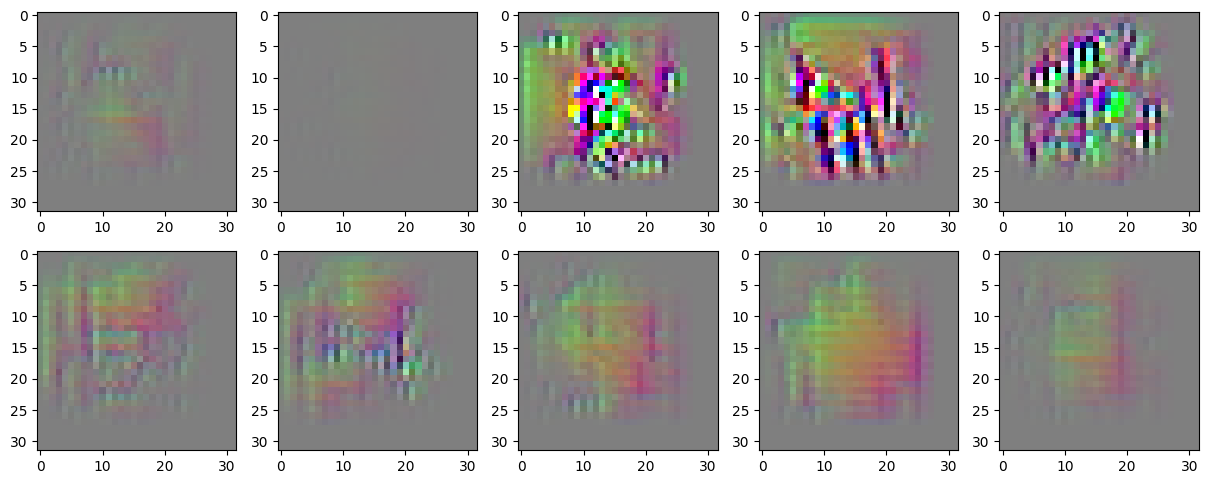

In [79]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(num_classes):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_grey[0+i,], (32, 32,3))), cmap=plt.cm.gray_r)

As we can see, the attack reveals certain structural properties of the training instances for each 
of the ten classes.

### Initialization with black image

In [80]:
# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_black, y)
class_gradient = np.reshape(class_gradient, (10, 32*32*3))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.000099


In [81]:
%%time

# Now we run the attack:
x_infer_from_black = attack.infer(x_init_black, y)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

Model inversion: 100%|██████████| 10/10 [20:25<00:00, 122.59s/it]

CPU times: total: 6min 49s
Wall time: 20min 25s


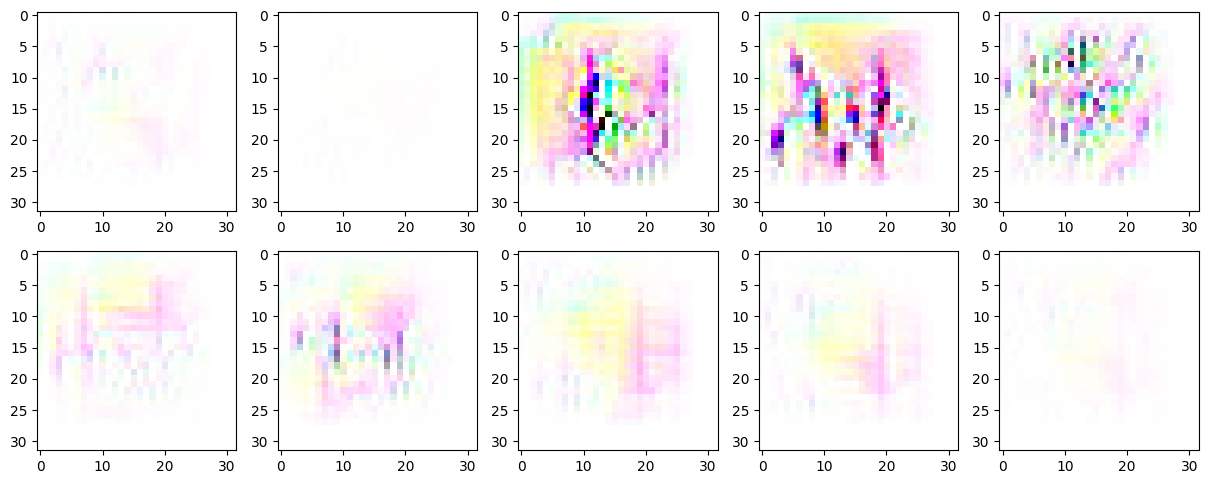

In [82]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_black[0+i,], (32, 32,3))), cmap=plt.cm.gray_r)

### Initialization with random image

In [83]:
# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_random, y)
class_gradient = np.reshape(class_gradient, (10, 32*32*3))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.000018


In [84]:
%%time

# Now we run the attack:
x_infer_from_random = attack.infer(x_init_random, y)

Model inversion: 100%|██████████| 10/10 [14:57<00:00, 89.74s/it]

CPU times: total: 5min 9s
Wall time: 14min 57s


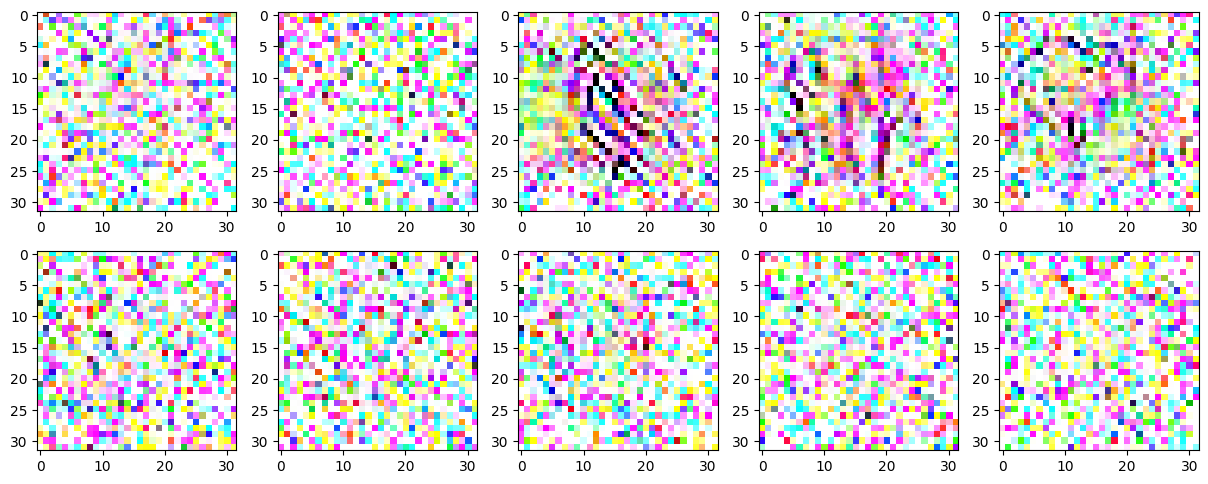

In [86]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_random[0+i,], (32, 32,3))), cmap=plt.cm.gray_r)

### Initialization with average image

In [88]:
# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_average, y)
class_gradient = np.reshape(class_gradient, (10, 32*32*3))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.000003


In [89]:
%%time

# Now we run the attack:
x_infer_from_average = attack.infer(x_init_average, y)

Model inversion: 100%|██████████| 10/10 [14:52<00:00, 89.21s/it]

CPU times: total: 3min 31s
Wall time: 14min 52s


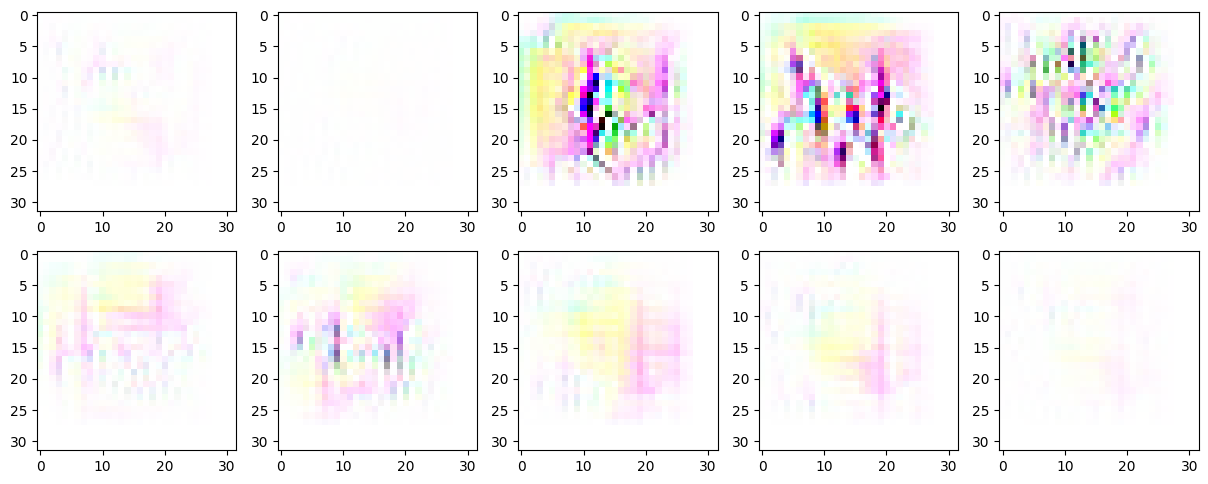

In [90]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_average[0+i,], (32, 32,3))), cmap=plt.cm.gray_r)